# Animating Tracer and Vector Fields
This notebook demonstrates the process of animating 2-D tracer and vector fields over sequential timesteps using Matplotlib animation. Several good Matplotlib animation tutorials can be found online:

http://matplotlib.org/1.4.1/examples/animation/index.html

https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/analysis/raw/tip/Idalia/Animations_with_Python.ipynb

However most of these deal with simple line objects, and adapting these examples to more complicated plots like `contourf` and `quiver` is not trivial. This notebook provides an example of animating more complicated plots using simulated salinity and currents from the Salish Sea NEMO Model available online at https://salishsea.eos.ubc.ca/erddap/griddap.

## Code structure
Since most research plots span many lines of code with several important variables, we separate our code into functions as much as possible. Below is the fundamental structure that we follow. Each section will become clear as we proceed.

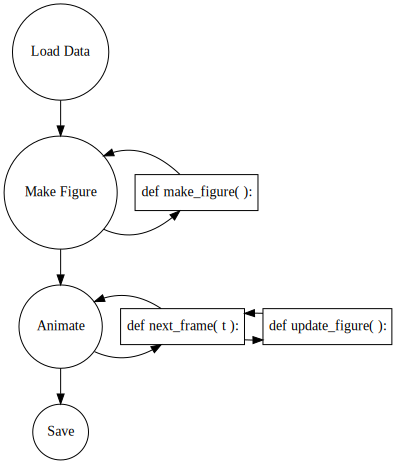

In [2]:
src = load_NEMO_ERDDAP.flow_diagram()
src

## Let's Get Started
First we'll need to import the necessary packages and set the `matplotlib inline` magic.

In [8]:
import numpy as np
import datetime as dtm
import dateutil.parser as dparser
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import load_NEMO_ERDDAP
from mpl_toolkits.basemap import Basemap

%matplotlib inline

### Load Data using XArray
We'll use outputs from the Salish Sea NEMO Model for this exercise. For simplicity, we'll download 24 hours of surface results. The function `load_NEMO` will return these results as a dictionary of `XArray` objects.

In [3]:
# Load data
timerange = ['2016 Jun 1 00:00', '2016 Jun 2 00:00']
depth = 0
NEMO = load_NEMO_ERDDAP.load_NEMO(timerange, depth)

`NEMO` is a dictionary with lat, lon, salinity, u, and v

In [4]:
NEMO.keys()

dict_keys(['lat', 'lon', 'v', 'u', 'salinity'])

Each field, salinity for instance, is an `xarray.DataArray` object.

In [5]:
NEMO['salinity']

<xarray.DataArray 'salinity' (time: 24, gridY: 341, gridX: 298)>
[2438832 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2016-06-01T00:30:00 2016-06-01T01:30:00 ...
    depth    float32 0.5
  * gridY    (gridY) int16 230 231 232 233 234 235 236 237 238 239 240 241 ...
  * gridX    (gridX) int16 100 101 102 103 104 105 106 107 108 109 110 111 ...
Attributes:
    colorBarMaximum: 37.0
    colorBarMinimum: 32.0
    interval_operation: 10.0
    interval_write: 3600.0
    ioos_category: Salinity
    long_name: salinity
    online_operation: ave(X)
    standard_name: sea_water_practical_salinity

We can index and slice `xarray.DataArray` objects by index name easily using the `DataArray.sel()` function. The "nearest neighbor" method is useful if the indices we specify are not exact.

In [6]:
NEMO['salinity'].sel(time=timerange[0], method='nearest')

<xarray.DataArray 'salinity' (gridY: 341, gridX: 298)>
[101618 values with dtype=float64]
Coordinates:
    time     datetime64[ns] 2016-06-01T00:30:00
    depth    float32 ...
  * gridY    (gridY) int16 230 231 232 233 234 235 236 237 238 239 240 241 ...
  * gridX    (gridX) int16 100 101 102 103 104 105 106 107 108 109 110 111 ...
Attributes:
    colorBarMaximum: 37.0
    colorBarMinimum: 32.0
    interval_operation: 10.0
    interval_write: 3600.0
    ioos_category: Salinity
    long_name: salinity
    online_operation: ave(X)
    standard_name: sea_water_practical_salinity

### Make Figure
We'll need a figure that we wish to animate. In our case, we probably want to see surface salinity contours on a map. Let's start by making the map.

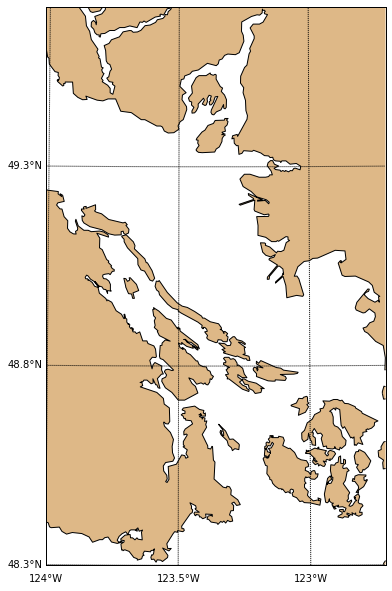

In [10]:
# Make figure window
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Define map window
w_map = [-124, -122.7, 48.3, 49.7]

# Make projection
m = Basemap(projection='lcc', resolution='h',
            lon_0=(w_map[1] - w_map[0]) / 2 + w_map[0],
            lat_0=(w_map[3] - w_map[2]) / 2 + w_map[2],
            llcrnrlon=w_map[0], urcrnrlon=w_map[1],
            llcrnrlat=w_map[2], urcrnrlat=w_map[3])

# Add features and labels
m.drawcoastlines()
m.fillcontinents(color='burlywood')
m.drawmeridians(np.arange(w_map[0], w_map[1], 0.5), labels=[0, 0, 0, 1])
m.drawparallels(np.arange(w_map[2], w_map[3], 0.5), labels=[1, 0, 0, 0])

plt.show()

Now we'll add the salinity contours. Since we're using `Basemap` we'll need to transform our lon/lat fields into map coordinates. We also need to specify a time index so we know which time step we're using. We'll also add a timestamp in the upper left corner. We're also going to apply a simple zero-mask to our salinity fields to remove the areas defined as land in the model.

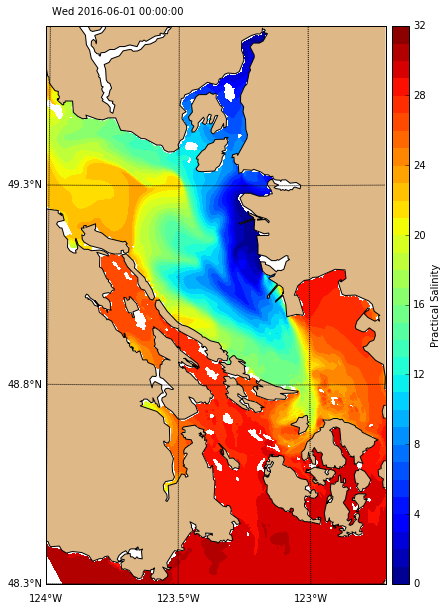

In [12]:
# Time index
time_ind = dparser.parse(timerange[0])

# Make figure window
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Define colormap
cmap = plt.get_cmap('jet')

# Define map window
w_map = [-124, -122.7, 48.3, 49.7]

# Make projection
m = Basemap(projection='lcc', resolution='h',
            lon_0=(w_map[1] - w_map[0]) / 2 + w_map[0],
            lat_0=(w_map[3] - w_map[2]) / 2 + w_map[2],
            llcrnrlon=w_map[0], urcrnrlon=w_map[1],
            llcrnrlat=w_map[2], urcrnrlat=w_map[3])

# Add features and labels
m.drawcoastlines()
m.fillcontinents(color='burlywood')
m.drawmeridians(np.arange(w_map[0], w_map[1], 0.5), labels=[0, 0, 0, 1])
m.drawparallels(np.arange(w_map[2], w_map[3], 0.5), labels=[1, 0, 0, 0])

# Transform lon/lat into basemap coordinates
NEMO['x_map'], NEMO['y_map'] = m(NEMO['lon'].values, NEMO['lat'].values)

# Plot salinity as contour object (zero-mask applied to salinity)
CONT_OBJ = ax.contourf(NEMO['x_map'], NEMO['y_map'],
                       np.ma.masked_values(NEMO['salinity'].sel(time=time_ind, method='nearest'), 0),
                       range(33), cmap=cmap)
m.colorbar(CONT_OBJ, label='Practical Salinity')

# Add timestamp
TEXT_OBJ = ax.text(0.02, 1.02, time_ind.strftime('%a %Y-%m-%d %H:%M:%S'), transform=ax.transAxes)

plt.show()

Now that our figure is complete, we can turn our code into a function `make_figure()` that can be called from our animation script. We need to return multiple figure object handles, we'll define a dictionary to do this.

In [13]:
def make_figure(time_ind, ax, cmap, w_map, NEMO):
    """
    """

    # Make projection
    m = Basemap(projection='lcc', resolution='h',
                lon_0=(w_map[1] - w_map[0]) / 2 + w_map[0],
                lat_0=(w_map[3] - w_map[2]) / 2 + w_map[2],
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3])

    # Add features and labels
    m.drawcoastlines()
    m.fillcontinents(color='burlywood')
    m.drawmeridians(np.arange(w_map[0], w_map[1], 0.5), labels=[0, 0, 0, 1])
    m.drawparallels(np.arange(w_map[2], w_map[3], 0.5), labels=[1, 0, 0, 0])

    # Transform lon/lat into basemap coordinates
    NEMO['x_map'], NEMO['y_map'] = m(NEMO['lon'].values, NEMO['lat'].values)

    # Plot salinity as contour object (zero-mask applied to salinity)
    CONT_OBJ = ax.contourf(NEMO['x_map'], NEMO['y_map'],
                           np.ma.masked_values(NEMO['salinity'].sel(time=time_ind, method='nearest'), 0),
                           range(33), cmap=cmap)
    m.colorbar(CONT_OBJ, label='Practical Salinity')

    # Add timestamp
    TEXT_OBJ = ax.text(0.02, 1.02, time_ind.strftime('%a %Y-%m-%d %H:%M:%S'), transform=ax.transAxes)
    
    # Return plot objects as dict
    PLOT_OBJS = {'CONT_OBJ': CONT_OBJ, 'TEXT_OBJ': TEXT_OBJ}
    
    return NEMO, PLOT_OBJS

Now we can call `make_figure()` from our main animation script (which is the just the leftover header lines of our previous figure script).

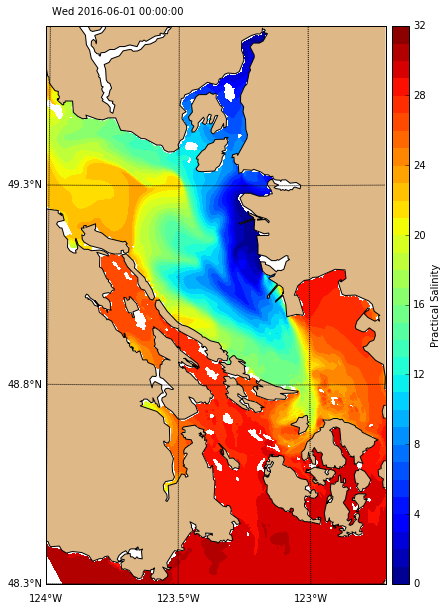

In [14]:
# Time index
time_ind = dparser.parse(timerange[0])

# Make figure window
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Define colormap
cmap = plt.get_cmap('jet')

# Define map window
w_map = [-124, -122.7, 48.3, 49.7]

# Make figure
NEMO, PLOT_OBJS = make_figure(time_ind, ax, cmap, w_map, NEMO)

plt.show()

### Step Figure Forward
Now that we have our figure, we need to step it forward to the next timestep. Our goal here is to keep as much of the figure static as possible (projection, coastline, labels) and only change the data. For a `contourf` object, we'll use the `collections` attribute to identify and clear the contours. Then we can re-plot salinity. We'll also need to update our time index and time stamp.

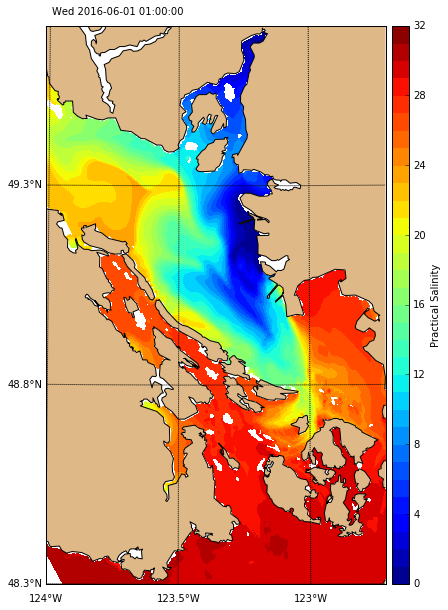

In [16]:
# Time index
starttime = dparser.parse(timerange[0])

# Make figure window
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Define colormap
cmap = plt.get_cmap('jet')

# Define map window
w_map = [-124, -122.7, 48.3, 49.7]

# Make figure
NEMO, PLOT_OBJS = make_figure(starttime, ax, cmap, w_map, NEMO)

# Step time index forward
time_ind = (starttime + dtm.timedelta(hours=1))

# Clear previous salinity contours
for C in PLOT_OBJS['CONT_OBJ'].collections:
    C.remove()

# Update salinity contours
PLOT_OBJS['CONT_OBJ'] = ax.contourf(NEMO['x_map'], NEMO['y_map'],
                        np.ma.masked_values(NEMO['salinity'].sel(time=time_ind, method='nearest'), 0),
                        range(33), cmap=cmap)

# Update timestamp
PLOT_OBJS['TEXT_OBJ'].set_text(time_ind.strftime('%a %Y-%m-%d %H:%M:%S'))

plt.show()

Now we can turn our figure update code into a function `update_figure()`.

In [17]:
def update_figure(time_ind, ax, cmap, NEMO, PLOT_OBJS):
    """
    """

    # Clear previous salinity contours
    for C in PLOT_OBJS['CONT_OBJ'].collections:
        C.remove()

    # Update salinity contours
    PLOT_OBJS['CONT_OBJ'] = ax.contourf(NEMO['x_map'], NEMO['y_map'],
                            np.ma.masked_values(NEMO['salinity'].sel(time=time_ind, method='nearest'), 0),
                            range(33), cmap=cmap)

    # Update timestamp
    PLOT_OBJS['TEXT_OBJ'].set_text(time_ind.strftime('%a %Y-%m-%d %H:%M:%S'))
    
    return PLOT_OBJS

That can be called from our animation script.

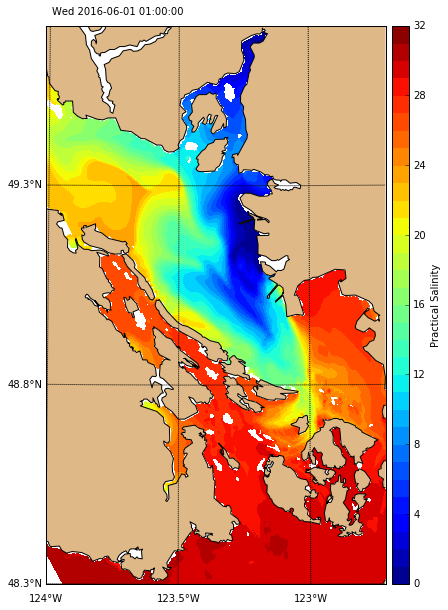

In [19]:
# Time index
starttime = dparser.parse(timerange[0])

# Make figure window
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Define colormap
cmap = plt.get_cmap('jet')

# Define map window
w_map = [-124, -122.7, 48.3, 49.7]

# Make figure
NEMO, PLOT_OBJS = make_figure(starttime, ax, cmap, w_map, NEMO)

# Step time index forward
time_ind = (starttime + dtm.timedelta(hours=1))

# Update figure
PLOT_OBJS = update_figure(time_ind, ax, cmap, NEMO, PLOT_OBJS)

plt.show()

### Animate
Now with our figure functions written, it's time to animate.

First we write a local function `next_frame(t, ...)` around our update figure code. The first argument of this function is an integer that will be iterated by the `matplotlib.animation` function. We will also need to pass PLOT_OBJS since it will change with each timestep. The remaining variables are known to the function since they are in the same cell.

Next we call `animation.FuncAnimation` and specify the figure handle, `next_frame` function, additional arguments, and number of frames. To save the animation we will select the FFMpeg writer (or AVConv if you have Libav) and specify the frames-per-second. We'll use a high bitrate for quality, but there is of course a tradeoff with file size.

In [21]:
# Time index
starttime = dparser.parse(timerange[0])

# Make figure window
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Define colormap
cmap = plt.get_cmap('jet')

# Define map window
w_map = [-124, -122.7, 48.3, 49.7]

# Make figure
NEMO, PLOT_OBJS = make_figure(starttime, ax, cmap, w_map, NEMO)

def next_frame(t, PLOT_OBJS):
    # Step time index forward
    time_ind = (starttime + dtm.timedelta(hours=t))

    # Update figure
    PLOT_OBJS = update_figure(time_ind, ax, cmap, NEMO, PLOT_OBJS)
    
    return PLOT_OBJS

# Animate
ANI = animation.FuncAnimation(fig, next_frame, fargs=[PLOT_OBJS], frames=24)
mywriter = animation.FFMpegWriter(fps=12, bitrate=10000)
ANI.save('/ocean/bmoorema/research/programming/swc/30Jun2016/mymovie.mp4', writer=mywriter)